线性回归不用做

In [11]:
import tensorflow as tf
print(tf.__version__)


2.13.0


学校tensorflow 版本 2.6.2

In [10]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
import sys, os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl


seed=12
np.random.seed(seed)
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

tf.random.set_seed(seed)

filename='SYSU.csv'

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi",
         "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

df_train=pd.read_csv(filename, names= columns, nrows=1500000, engine= 'python')
df_test=pd.read_csv(filename, names=columns, nrow=50000, skiprows=150000, engine='python')


def getTrainData(nVar):
    designMatrix = df_train.iloc[:, 1: nVar+1].values
    labels = df_train['signal'].values
    return (designMatrix, labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    labels=df_test['signal'].values
    return (designMatrix, labels)

def build_roc_curvel(probs, signal_bit, threshes):
    signal_probs = pd.Series(probs[:, 1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true']= signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        signal_df.loc[:,'accept']= signal_df['sig_prob']>thresh
        nSigCor = len(signal_df[(signal_df['accept'])&(signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[(signal_df['sig_true']==0.)&(~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig)
        Rejection.append(nBkgCor/nBkg)
        
    return Acceptance, Rejection

def runTensorFlowRegression(nVar, alpha):
    
    x=tf.placeholder(tf.float32, [None, nVar])
    W=tf.Variable(tf.zeros([nVar,2]))
    c=tf.Variable(tf.zeros([2]))
    
    y=tf.nn.softmax(tf.matmul(x, W)+b)
    y_=tf.placeholder(tf.float32, [None, 2])
    # cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y_)+alpha*tf.nn.12.loss(W))
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y) + alpha * tf.nn.l2_loss(W))

    
    train_step=tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    
    init = tf.gloab_variables_initializer()
    sess= tf.Session()
    sess.run(init)
    Var_train ,Sig_train_bit1 = getTrainData(nVar)
    
    Sig_train_bit0= Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0, Sig_train_bit1))
    
    n_data = len(Sig_train_bit1)
    
    minibatch_size= 1000
    n_minibatch = n_data//minibatch_size
    print('\t Train with %i minibatches, dataset size is %i'%(n_minibatch, n_data))
    for i in range(0,n_minibatch):
        sys.stdout.write("%.3f%%completed \r"%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i* minibatch_size
        end= (i + 1)*minibatch_size-1
        batch_x= Var_train[start:end]
        batch_y= Sig_train[start: end]
        sess.run(train_step, feed_dict= {x:batch_x, y_:batch_y})
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        Var_test = df_test.iloc[:, 1:nVar+1].values
        
        Sig_test_bit1=df_test['signal'].values
        Sig_test_bit0= Sig_test_bit1.copy()
        Sig_test_bit0=1-Sig_train_bit0
        Sig_test = np.column_stack((Sig_test_bit0, Sig_test_bit1))
        print("\t Accuracy for alpha %.1E : %.3f" %(alpha.sess.run(accuracy, feef_dict={x:Var_test, y_: Sig_test})))
        
        weights= W.eval(session=sess)
        
        probs = y.eval(feed_dict = {x: Var_test}, session = sess)
        
    print('\t Computing ROC curve ...')
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curvel(probs, Sig_test_bit1, threshes)
    
    return (probs, Acceptance, Rejection)


alphas = np.logspace(-10,-1, 11)
fig= plt.figure()
ax = fig.add_subplot(111)
it = 0
for alpha in alphas:
    print('training for alpha = %.2E'%alpha)
    c1= 1*(float(it)% 3.)/3.0
    c2= 1.*(float(it)%9.)/9.0
    c3 = 1.*( float(it)% 27)/27.0
    probsSimple.accep.rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep, rej, c=[[c1, c2, c3]],label='Alpha: %.1E'%alpha)
    it+=1
    
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc = 'lower left', fontsize= 'small');
plt.show()

probsSimple, accep, rej =runTensorFlowRegression(8,.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']= Signal
df_test_acc_sig = df_test_acc.query('SIG == 1')
df_test_acc_bkg = df_test_acc.query('SIG == 0')
df_test_acc_sig.plot(kind= 'hist', y= 'PROB', color = 'blue', alpha = 0.5, bins = np.linspace(0,1,10), label= 'Signal')
df_test_acc_bkg.plot(kind = 'hist', y= 'PROB', color = 'red',  label= 'Backgrund')        



FileNotFoundError: [Errno 2] No such file or directory: 'SYSU.csv'

## 逻辑回归

Training for alpha = 1.00E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 7.94E-10
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.770
	 Computing ROC curve ...
Training for alpha = 6.31E-09
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.770
	 Computing ROC curve ...
Training for alpha = 5.01E-08
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-08 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.98E-07
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-07 : 0.770
	 Computing ROC curve ...
Training for alpha = 3.16E-06
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-06 : 0.770
	 Computing ROC curve ...
Training for alpha = 2.51E-05
	 Training with 1500 minibatches, dataset size is 1500000
	 Accu

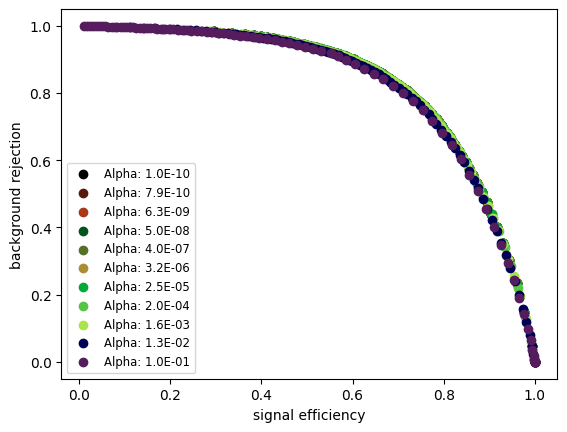

	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-05 : 0.783
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.3E-09 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.6E-08 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 2.0E-07 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 2.5E-06 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-05 : 0.788
	 Computing ROC curve ...
	 Training with 1500 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-04 : 0.787
	 Computing ROC curve ...
	 Training with 1500 minibatches

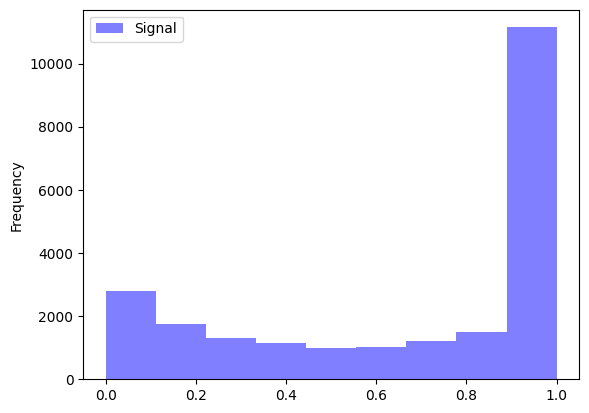

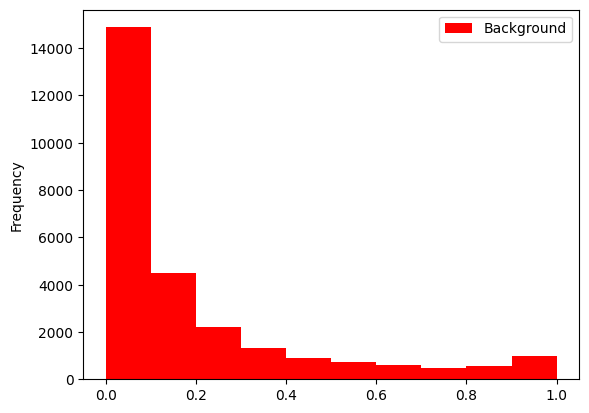

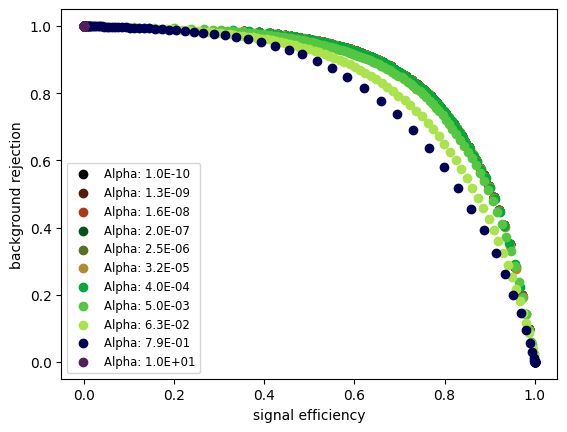

Accuracy on test data with alpha 1.00E-10 : 0.675
Accuracy on test data with alpha 1.26E-09 : 0.645
Accuracy on test data with alpha 1.58E-08 : 0.652
Accuracy on test data with alpha 2.00E-07 : 0.687
Accuracy on test data with alpha 2.51E-06 : 0.768
Accuracy on test data with alpha 3.16E-05 : 0.768
Accuracy on test data with alpha 3.98E-04 : 0.769
Accuracy on test data with alpha 5.01E-03 : 0.767
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.543
Accuracy on test data with alpha 1.00E+01 : 0.543


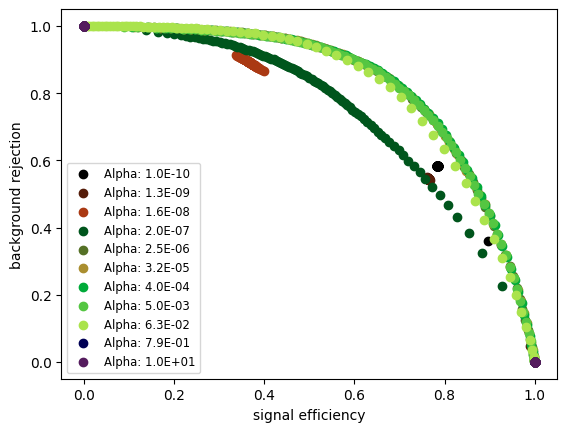

Accuracy on test data with alpha 5.00E-01 : 0.543
Accuracy on test data with alpha 1.00E-10 : 0.702
Accuracy on test data with alpha 1.26E-09 : 0.779
Accuracy on test data with alpha 1.58E-08 : 0.693
Accuracy on test data with alpha 2.00E-07 : 0.636
Accuracy on test data with alpha 2.51E-06 : 0.726
Accuracy on test data with alpha 3.16E-05 : 0.787
Accuracy on test data with alpha 3.98E-04 : 0.790
Accuracy on test data with alpha 5.01E-03 : 0.783
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.543
Accuracy on test data with alpha 1.00E+01 : 0.457


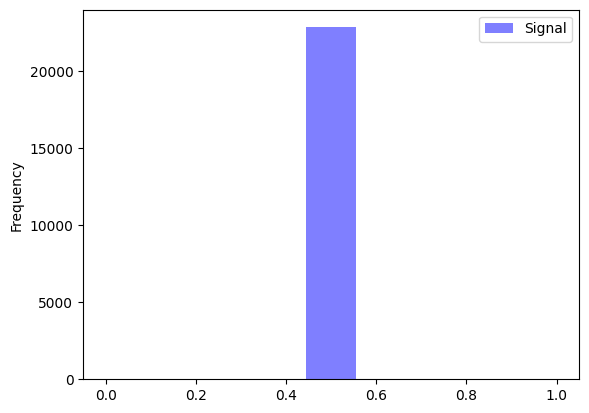

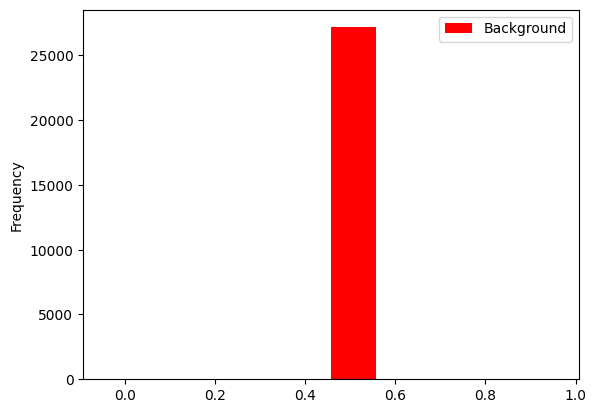

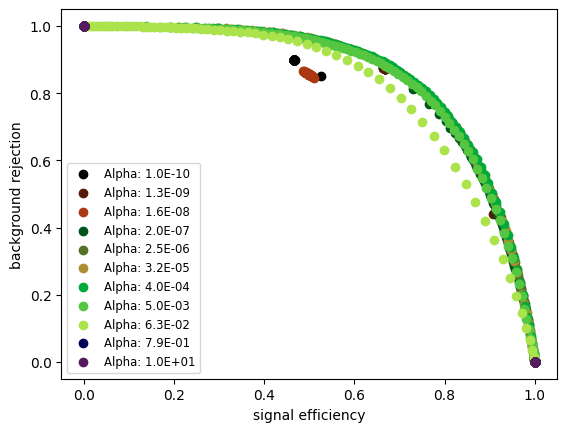

Accuracy on test data with alpha 1.00E-10 : 0.639
Accuracy on test data with alpha 1.26E-09 : 0.638
Accuracy on test data with alpha 1.58E-08 : 0.657
Accuracy on test data with alpha 2.00E-07 : 0.663
Accuracy on test data with alpha 2.51E-06 : 0.767
Accuracy on test data with alpha 3.16E-05 : 0.766
Accuracy on test data with alpha 3.98E-04 : 0.769
Accuracy on test data with alpha 5.01E-03 : 0.767
Accuracy on test data with alpha 6.31E-02 : 0.755
Accuracy on test data with alpha 7.94E-01 : 0.694
Accuracy on test data with alpha 1.00E+01 : 0.543


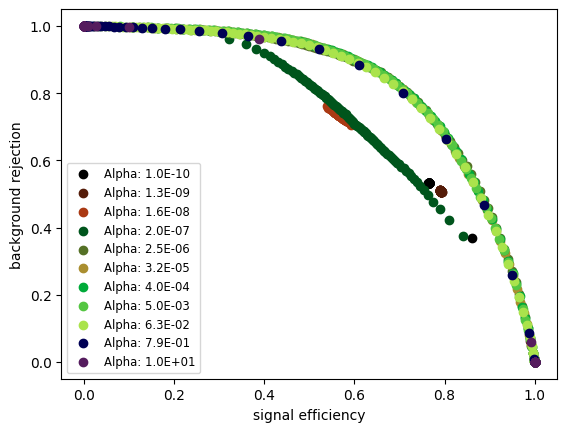

Accuracy on test data with alpha 1.00E-10 : 0.751
Accuracy on test data with alpha 1.26E-09 : 0.606
Accuracy on test data with alpha 1.58E-08 : 0.762
Accuracy on test data with alpha 2.00E-07 : 0.681
Accuracy on test data with alpha 2.51E-06 : 0.781
Accuracy on test data with alpha 3.16E-05 : 0.787
Accuracy on test data with alpha 3.98E-04 : 0.789
Accuracy on test data with alpha 5.01E-03 : 0.785
Accuracy on test data with alpha 6.31E-02 : 0.760
Accuracy on test data with alpha 7.94E-01 : 0.719
Accuracy on test data with alpha 1.00E+01 : 0.457


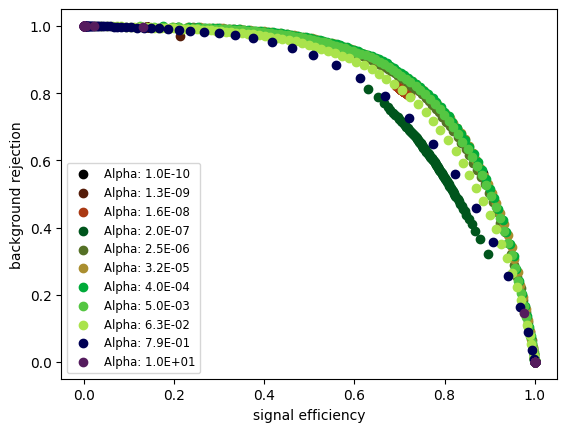

In [10]:
# Importing the SUSY Data set
import sys, os
import pandas as pd

import numpy as np
import warnings
#Commnet the next line on to turn off warnings
#warnings.filterwarnings('ignore')


seed=12
np.random.seed(seed)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.set_random_seed(seed)

# Download the SUSY.csv (about 2GB) from UCI ML archive and save it in the same directory as this jupyter notebook
# See: https://archive.ics.uci.edu/ml/machine-learning-databases/00279/
filename="SUSY.csv"

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 1,500,000 rows as train data, 50,000 as test data
df_train=pd.read_csv(filename,names=columns,nrows=1500000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=1500000,engine='python')

import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
#import ml_style as style #optional styling sheet
#mpl.rcParams.update(style.style) #optional styling sheet

def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_train['signal'].values # labels (0 or 1)
    return (designMatrix,labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_test['signal'].values
    return (designMatrix,labels)

# define
def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection

# let's define this as a function so we can call it easily
def runTensorFlowRegression(nVar,alpha):

    #make data array placeholder for just first 8 simple features
    x = tf.placeholder(tf.float32,[None,nVar])
    #make weights and bias
    W = tf.Variable(tf.zeros([nVar,2])) #we will make y 'onehot' 0 bit is bkg, 1 bit is signal
    b = tf.Variable(tf.zeros([2]))

    #make 'answer variable'
    y = tf.nn.softmax(tf.matmul(x, W) + b)
    #placeholder for correct answer
    y_ = tf.placeholder(tf.float32, [None, 2])
    #cross entropy with L2 regularizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=y_)+alpha*tf.nn.l2_loss(W))

    #define training step
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    #initialize variables
    init = tf.global_variables_initializer()
    #setup session
    sess = tf.Session()
    sess.run(init)

    #ok now everything is setup for tensorflow, but we need the data in a useful form
    #first let's get the variables
    Var_train, Sig_train_bit1 = getTrainData(nVar)
    #now the signal
    Sig_train_bit0 = Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0,Sig_train_bit1))

    ######## ------- TRAINING ----------############
    #Now perform minibatch gradient descent with minibatches of size 100:
    n_data = len(Sig_train_bit1)
    minibatch_size = 1000
    n_minibatch = n_data//minibatch_size
    print('\t Training with %i minibatches, dataset size is %i'%(n_minibatch,n_data))
    for i in range(0, n_minibatch):
        sys.stdout.write("%.3f %% completed \r"%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i*minibatch_size
        end = (i+1)*minibatch_size-1

        batch_x = Var_train[start:end]
        batch_y = Sig_train[start:end]
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})


    # Accuracy function:
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    ######## ------- TESTING ----------############
    # Setup test data
    Var_test = df_test.iloc[:,1:nVar+1].values

    # Now the signal
    Sig_test_bit1 = df_test['signal'].values

    Sig_test_bit0 = Sig_test_bit1.copy()
    Sig_test_bit0 = 1 - Sig_test_bit0
    Sig_test = np.column_stack((Sig_test_bit0,Sig_test_bit1))
    print("\t Accuracy for alpha %.1E : %.3f" %(alpha,sess.run(accuracy, feed_dict={x: Var_test, y_: Sig_test})))

    # Get the weights
    weights = W.eval(session=sess)
    # Get probabilities assigned (i.e. evaluate y on test data)
    probs = y.eval(feed_dict = {x: Var_test}, session = sess)
    # now let's get the signal efficiency and background rejection on the test data
    print('\t Computing ROC curve ...')
    # build ROC curve by scanning over thresholds of probability of being
    # a background event and calculating signal efficiency/background rejection
    # at each threshold
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, Sig_test_bit1, threshes)

    return (probs,Acceptance,Rejection)

# We sweep the L2 regularizer strength (alpha) over 10 decades
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

# now let's investigate how mixed the events are
probsSimple,accep,rej = runTensorFlowRegression(16,.00001) # train the model for 8 variables and alpha=.00001更改变量=8 or 其他
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probsSimple,accep,rej = runTensorFlowRegression(18,alpha)
    ax.scatter(accep,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

def runSciKitRegressionL2(nVar, alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log_loss", penalty="l2",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)


def runSciKitRegressionL1(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log_loss", penalty="l1",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs,Acceptance,Rejection)

alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

# now let's investigate how mixed the events are
probsSimple,accep,rej = runSciKitRegressionL1(8,.5)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')


alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()


alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL2(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()




Accuracy on test data with alpha 5.00E-01 : 0.543


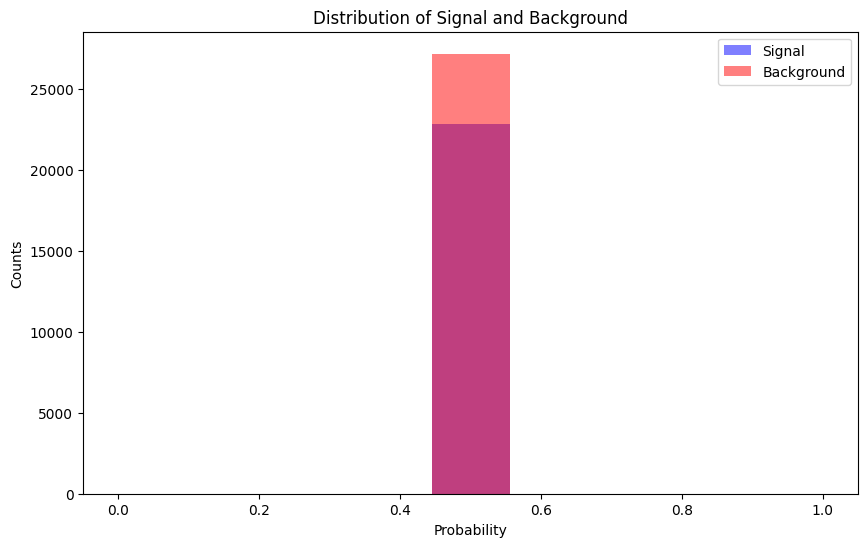

In [9]:
# 使用18个变量进行训练
probsSimple, accep, rej = runSciKitRegressionL1(18, .5)

Signal = df_test.iloc[:, 0:1]

df_test_acc = pd.DataFrame({'PROB': probsSimple[:, 1]})
df_test_acc['SIG'] = Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')

# 画出信号和本底的分布图
plt.figure(figsize=(10,6))

plt.hist(df_test_acc_sig['PROB'], bins=np.linspace(0,1,10), alpha=0.5, label='Signal', color='blue')
plt.hist(df_test_acc_bkg['PROB'], bins=np.linspace(0,1,10), alpha=0.5, label='Background', color='red')

plt.xlabel('Probability')
plt.ylabel('Counts')
plt.title('Distribution of Signal and Background')
plt.legend(loc='upper right')

plt.show()


## 集合模型

Size of dataset : 100000
Training on 90000 examples with 18 features
Predicting on 10000 examples with 18 features

Model Accuracy with all features: 77.85%
The AUC score with all features is 0.77
Run time with all features: 9.14 sec


Training on 90000 examples with 8 features
Predicting on 10000 examples with 8 features

Model Accuracy with just low-level kinematic features: 78.61%
The low-level AUC score is 0.78
Run time with low-level features: 0.69 sec


Training on 90000 examples with 10 features

Training on 10000 examples with 10 features
Model Accuracy with just high-level features: 78.61%
The high-level AUC score is 0.78
Run time with high-level features: 0.71 sec




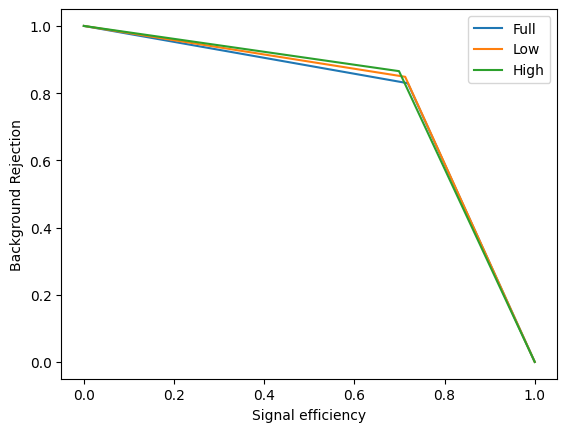

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#Filename [CHANGE THIS TO YOUR FILENAME FOR SUSY]
filename='./SUSY.csv'

#Read in SUSY File. We will only work with subset of data for demonstration purposes.

features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2',
 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
 'missing energy magnitude', 'missing energy phi']

high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

#Number of datapoints to work with
N = 100000
print("Size of dataset : %i"%N)
df = pd.read_csv(filename, header=None,nrows=N,engine='python')
df.columns=features
y = df['SUSY'].values
X = df[[col for col in df.columns if col!="SUSY"]]

#Make datasets using only the 8 low-level features and 10 high-level features
X_low=X[low_features]
X_high=X[high_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y, test_size=.1, random_state=0)
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y, test_size=.1, random_state=0)

from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000)
#Train and time classifier
start_time = time.time()
XGBclassifier.fit(X_train, y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))


#Rerun with just low-level kinematic features with default parameters

print("Training on %i examples with %i features"%X_low_train.shape)
XGBclassifier_low = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
#Train and time classifier
start_time = time.time()
XGBclassifier_low.fit(X_low_train, y_low_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_low_test.shape)
y_low_pred = XGBclassifier_low.predict(X_low_test)

#Print Results
print("Model Accuracy with just low-level kinematic features: {:.2f}%".format(100*XGBclassifier_low.score(X_low_test, y_low_test)))
print("The low-level AUC score is {:.2f}".format(roc_auc_score(y_test,y_low_pred)))
print("Run time with low-level features: {:.2f} sec\n\n".format(run_time))


#Rerun with just high-level kinematic features with default parameters

print("Training on %i examples with %i features\n"%X_high_train.shape)
XGBclassifier_high = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
#Train and time classifier
start_time = time.time()
XGBclassifier_high.fit(X_high_train, y_high_train)
run_time = time.time() - start_time

print("Training on %i examples with %i features"%X_high_test.shape)
#Make Predictions
y_high_pred = XGBclassifier_high.predict(X_high_test)

#Print Results
print("Model Accuracy with just high-level features: {:.2f}%".format(100*XGBclassifier_low.score(X_low_test, y_low_test)))
print("The high-level AUC score is {:.2f}".format(roc_auc_score(y_test,y_high_pred)))
print("Run time with high-level features: {:.2f} sec\n\n".format(run_time))

#import ml_style as style
import matplotlib as mpl
#mpl.rcParams.update(style.style)
import matplotlib.pyplot as plt

# fig=plt.figure()
# xgb.plot_importance(XGBclassifier, ax=plt.gca())
# fig.subplots_adjust(left=0.4)  #
# #fig.savefig('SUSYXGBoost1.pdf')

# fig=plt.figure()
# xgb.plot_importance(XGBclassifier_low, ax=plt.gca())
# fig.subplots_adjust(left=0.4)
# #fig.savefig('SUSYXGBoost2.pdf')
# fig=plt.figure()
# xgb.plot_importance(XGBclassifier_high, ax=plt.gca())
# fig.subplots_adjust(left=0.4)
# fig.savefig('SUSYXGBoost3.pdf')


from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)
fpr_low, tpr_low, _ = roc_curve(y_test, y_low_pred)
fpr_high, tpr_high, _ = roc_curve(y_test, y_high_pred)
plt.figure(1)
plt.plot(tpr, 1-fpr, label='Full')
plt.plot(tpr_low, 1-fpr_low, label='Low')
plt.plot(tpr_high, 1-fpr_high, label='High')
plt.legend(loc=1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background Rejection')
plt.show()
# plt.savefig("SUSY_roc_XGBoost.pdf")

## DNN

## 1

Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.732454
Train Epoch: 1 [100/800 (12%)]	Loss: 0.640613
Train Epoch: 1 [200/800 (25%)]	Loss: 0.723948
Train Epoch: 1 [300/800 (38%)]	Loss: 0.600943
Train Epoch: 1 [400/800 (50%)]	Loss: 0.749902
Train Epoch: 1 [500/800 (62%)]	Loss: 0.787560
Train Epoch: 1 [600/800 (75%)]	Loss: 0.711694
Train Epoch: 1 [700/800 (88%)]	Loss: 0.745844

Test set: Average loss: 0.6872, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.654344
Train Epoch: 2 [100/800 (12%)]	Loss: 0.548778
Train Epoch: 2 [200/800 (25%)]	Loss: 0.647273
Train Epoch: 2 [300/800 (38%)]	Loss: 0.774238
Train Epoch: 2 [400/800 (50%)]	Loss: 0.664104


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [500/800 (62%)]	Loss: 0.755661
Train Epoch: 2 [600/800 (75%)]	Loss: 0.625494
Train Epoch: 2 [700/800 (88%)]	Loss: 0.672991

Test set: Average loss: 0.6868, Accuracy: 109/200 (54.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.697225
Train Epoch: 3 [100/800 (12%)]	Loss: 0.677755
Train Epoch: 3 [200/800 (25%)]	Loss: 0.691703
Train Epoch: 3 [300/800 (38%)]	Loss: 0.816588
Train Epoch: 3 [400/800 (50%)]	Loss: 0.652826
Train Epoch: 3 [500/800 (62%)]	Loss: 0.697007
Train Epoch: 3 [600/800 (75%)]	Loss: 0.677167
Train Epoch: 3 [700/800 (88%)]	Loss: 0.721561

Test set: Average loss: 0.6865, Accuracy: 109/200 (54.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.652867
Train Epoch: 4 [100/800 (12%)]	Loss: 0.717385
Train Epoch: 4 [200/800 (25%)]	Loss: 0.781691
Train Epoch: 4 [300/800 (38%)]	Loss: 0.677011
Train Epoch: 4 [400/800 (50%)]	Loss: 0.651080
Train Epoch: 4 [500/800 (62%)]	Loss: 0.686692
Train Epoch: 4 [600/800 (75%)]	Loss: 0.716992
Train Epoch: 4 [700/800 (88%)]	Loss: 0.718167

Test se

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.693378
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.696747
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.663673
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.687764
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.702713

Test set: Average loss: 0.6884, Accuracy: 1070/2000 (53.500%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.692937
Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.702793
Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.697296
Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.701563
Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.678569
Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.691374
Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.708445
Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.700494

Test set: Average loss: 0.6883, Accuracy: 1071/2000 (53.550%)

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.671974
Train Epoch: 4 [1000/8000 (12%)]	Loss: 0.699267
Train Epoch: 4 [2000/8000 (25%)]	Loss: 0.679213
Train Epoch: 4 [3000/8000 (38%)]	Loss: 0.678393
Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.686321
Train Epoch: 4 [

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6990, Accuracy: 9115/20000 (45.575%)

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.712005
Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.709515
Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.703378
Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.706835
Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.711065
Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.704973
Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.708498
Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.702559

Test set: Average loss: 0.6989, Accuracy: 9124/20000 (45.620%)

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.709688
Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.698369
Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.708620
Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.701137
Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.706827
Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.709733
Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.712157
Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.708810

Test set: Average loss: 0.6987, Accuracy: 9129/20000 (45.645%)

Train Epoch: 4 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7001, Accuracy: 17602/40000 (44.005%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.705975
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.708230
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.706395
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.704845
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.702706
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.706650
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.705066
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.706176

Test set: Average loss: 0.7000, Accuracy: 17630/40000 (44.075%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.705903
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.705434
Train Epoch: 3 [40000/160000 (25%)]	Loss: 0.705613
Train Epoch: 3 [60000/160000 (38%)]	Loss: 0.701805
Train Epoch: 3 [80000/160000 (50%)]	Loss: 0.701164
Train Epoch: 3 [100000/160000 (62%)]	Loss: 0.706852
Train Epoch: 3 [120000/160000 (75%)]	Loss: 0.707321
Train Epoch: 3 [140000/160000 (88%)]	Loss: 0.702315

Test set: Average loss: 0.6999, Accuracy: 17657/40000 (

/var/folders/kt/7k22p1ns6l7ggtc7ck9nkqbw0000gn/T/ipykernel_33699/160859846.py:323: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + x)
/var/folders/kt/7k22p1ns6l7ggtc7ck9nkqbw0000gn/T/ipykernel_33699/160859846.py:324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + y)


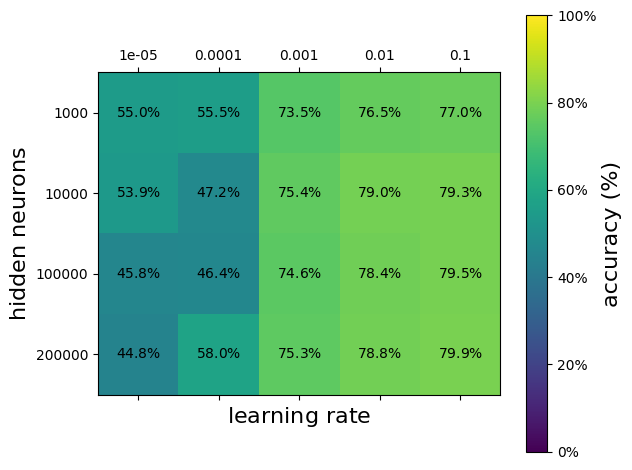

In [16]:
from __future__ import print_function, division
import os, sys
import numpy as np
import torch  # pytorch package, allows using GPUs

# fix seed
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)

from torchvision import datasets  # load data


class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only.
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features = ['SUSY', 'lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta',
                    'lepton 2 phi',
                    'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R',
                    'MT2',
                    'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features = ['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
                        'missing energy magnitude', 'missing energy phi']

        high_features = ['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b',
                         'cos(theta_r1)']

        # Number of datapoints to work with
        df = pd.read_csv(root_dir + data_file, header=None, nrows=dataset_size, engine='python')
        df.columns = features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col != "SUSY"]]

        # set training and test data size
        train_size = int(0.8 * dataset_size)
        self.train = train

        if self.train:
            X = X[:train_size]
            Y = Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X = X[train_size:]
            Y = Y[train_size:]
            print("Testing on {} examples".format(dataset_size - train_size))

        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data = (X.values.astype(np.float32), Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data = (X[high_features].values.astype(np.float32), Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data = (X[low_features].values.astype(np.float32), Y.values.astype(int))
            print("Using both low-level features only.")

    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample = (self.data[0][idx, ...], self.data[1][idx])

        if self.transform:
            sample = self.transform(sample)

        return sample


def load_data(args):
    data_file = 'SUSY.csv'
    root_dir = "./"

    kwargs = {}  # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file, root_dir, args.dataset_size, train=True, high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file, root_dir, args.dataset_size, train=False, high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


import torch.nn as nn  # construct NN

class model(nn.Module):
    def __init__(self, high_level_feats=None):
        super(model, self).__init__()

        # 根据是否使用高级特征来决定输入特征的数量
        if high_level_feats is None:
            input_features = 18  # 使用所有特征
        elif high_level_feats:
            input_features = 10  # 仅使用高级特征
        else:
            input_features = 8   # 仅使用低级特征

        # 第一层全连接
        self.fc1 = nn.Linear(input_features, 200)
        # 添加第一层的批量规范化
        self.batchnorm1 = nn.BatchNorm1d(200)

        # 第二层全连接
        self.fc2 = nn.Linear(200, 100)
        # 添加第二层的批量规范化
        self.batchnorm2 = nn.BatchNorm1d(100)

        # 第三层全连接
        self.fc3 = nn.Linear(100, 2)


    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        # x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)

        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        # x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)

        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x, dim=1)

        return x


import torch.nn.functional as F  # implements forward and backward definitions of an autograd operation
import torch.optim as optim  # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc


def evaluate_model(args, train_loader, test_loader):
    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)

    # optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()

            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0  # loss function on test data
        correct = 0  # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item()  # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        return test_loss, correct / len(test_loader.dataset)

    ################################################

    train_loss = np.zeros((args.epochs,))
    test_loss = np.zeros_like(train_loss)
    test_accuracy = np.zeros_like(train_loss)

    epochs = range(1, args.epochs + 1)
    for epoch in epochs:
        train_loss[epoch - 1] = train(epoch)
        test_loss[epoch - 1], test_accuracy[epoch - 1] = test()

    return test_loss[-1], test_accuracy[-1]


def grid_search(args):
    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes = [1000, 10000, 100000, 200000]  # np.logspace(2,5,4).astype('int')
    learning_rates = np.logspace(-5, -1, 5)

    # pre-alocate data
    test_loss = np.zeros((len(dataset_sizes), len(learning_rates)), dtype=np.float64)
    test_accuracy = np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size = dataset_size
        args.batch_size = int(0.01 * dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr = lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" % (dataset_size, lr))

            test_loss[i, j], test_accuracy[i, j] = evaluate_model(args, train_loader, test_loader)

    plot_data(learning_rates, dataset_sizes, test_accuracy)


import matplotlib.pyplot as plt


def plot_data(x, y, data):
    # plot results
    fontsize = 16

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)

    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)', rotation=90, fontsize=fontsize)
    cbar.set_ticks([0, .2, .4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format(100 * data[j, i])
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x = [str(i) for i in x]
    y = [str(i) for i in y]

    ax.set_xticklabels([''] + x)
    ax.set_yticklabels([''] + y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$', fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$', fontsize=fontsize)

    plt.tight_layout()

    plt.show()


import argparse  # handles arguments
import sys;

sys.argv = [''];
del sys  # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                    help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                    help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                    help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)

## 2

Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.732454
Train Epoch: 1 [100/800 (12%)]	Loss: 0.641052
Train Epoch: 1 [200/800 (25%)]	Loss: 0.723083
Train Epoch: 1 [300/800 (38%)]	Loss: 0.603379
Train Epoch: 1 [400/800 (50%)]	Loss: 0.749597
Train Epoch: 1 [500/800 (62%)]	Loss: 0.783403
Train Epoch: 1 [600/800 (75%)]	Loss: 0.711337
Train Epoch: 1 [700/800 (88%)]	Loss: 0.746036

Test set: Average loss: 0.6849, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.652943


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [100/800 (12%)]	Loss: 0.551652
Train Epoch: 2 [200/800 (25%)]	Loss: 0.646102
Train Epoch: 2 [300/800 (38%)]	Loss: 0.768043
Train Epoch: 2 [400/800 (50%)]	Loss: 0.657143
Train Epoch: 2 [500/800 (62%)]	Loss: 0.746879
Train Epoch: 2 [600/800 (75%)]	Loss: 0.630891
Train Epoch: 2 [700/800 (88%)]	Loss: 0.671736

Test set: Average loss: 0.6828, Accuracy: 110/200 (55.000%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.684597
Train Epoch: 3 [100/800 (12%)]	Loss: 0.668224
Train Epoch: 3 [200/800 (25%)]	Loss: 0.693982
Train Epoch: 3 [300/800 (38%)]	Loss: 0.790498
Train Epoch: 3 [400/800 (50%)]	Loss: 0.641852
Train Epoch: 3 [500/800 (62%)]	Loss: 0.686821
Train Epoch: 3 [600/800 (75%)]	Loss: 0.664862
Train Epoch: 3 [700/800 (88%)]	Loss: 0.713205

Test set: Average loss: 0.6807, Accuracy: 111/200 (55.500%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.657710
Train Epoch: 4 [100/800 (12%)]	Loss: 0.704838
Train Epoch: 4 [200/800 (25%)]	Loss: 0.763088
Train Epoch: 4 [300/800 (38%)]	Loss: 0.678677
Train Ep

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6851, Accuracy: 1123/2000 (56.150%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.693301
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.715464
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.693816
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.689709
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.690986
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.660281
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.681118
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.696476

Test set: Average loss: 0.6818, Accuracy: 1161/2000 (58.050%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.686520
Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.694066
Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.689665
Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.694048
Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.671482
Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.683348
Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.698388
Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.691848

Test set: Average loss: 0.6786, Accuracy: 1193/2000 (59.650%)

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.668570
Trai

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6927, Accuracy: 9317/20000 (46.585%)

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.706152
Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.702186
Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.695723
Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.698481
Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.700902
Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.695508
Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.697492
Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.692230

Test set: Average loss: 0.6866, Accuracy: 9521/20000 (47.605%)

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.698217
Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.685771
Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.695160
Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.687840
Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.691289
Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.694790
Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.694461
Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.691744

Test set: Average loss: 0.6807, Accuracy: 9770/20000 (48.850%)

Train Epoch: 4 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6936, Accuracy: 19372/40000 (48.430%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.699492
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.701455
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.697877
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.696859
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.693636
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.696109
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.693541
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.695283

Test set: Average loss: 0.6874, Accuracy: 21296/40000 (53.240%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.693659
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.693468
Train Epoch: 3 [40000/160000 (25%)]	Loss: 0.691484
Train Epoch: 3 [60000/160000 (38%)]	Loss: 0.687980
Train Epoch: 3 [80000/160000 (50%)]	Loss: 0.686009
Train Epoch: 3 [100000/160000 (62%)]	Loss: 0.692265
Train Epoch: 3 [120000/160000 (75%)]	Loss: 0.690806
Train Epoch: 3 [140000/160000 (88%)]	Loss: 0.684967

Test set: Average loss: 0.6812, Accuracy: 22744/40000 (

/var/folders/kt/7k22p1ns6l7ggtc7ck9nkqbw0000gn/T/ipykernel_33699/2624342282.py:318: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + x)
/var/folders/kt/7k22p1ns6l7ggtc7ck9nkqbw0000gn/T/ipykernel_33699/2624342282.py:319: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + y)


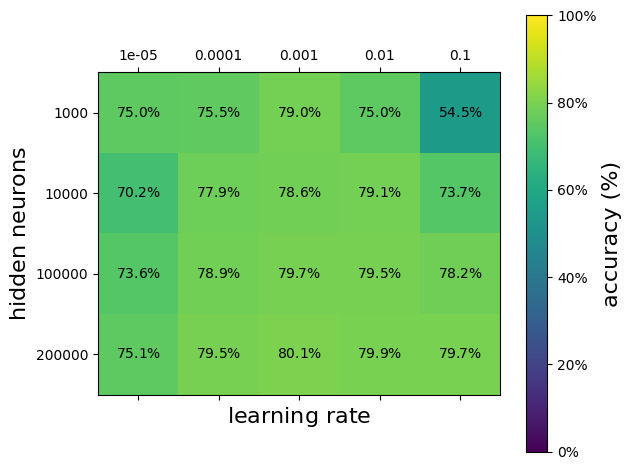

In [17]:
from __future__ import print_function, division
import os, sys
import numpy as np
import torch  # pytorch package, allows using GPUs

# fix seed
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)

from torchvision import datasets  # load data


class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only.
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features = ['SUSY', 'lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta',
                    'lepton 2 phi',
                    'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R',
                    'MT2',
                    'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features = ['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
                        'missing energy magnitude', 'missing energy phi']

        high_features = ['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b',
                         'cos(theta_r1)']

        # Number of datapoints to work with
        df = pd.read_csv(root_dir + data_file, header=None, nrows=dataset_size, engine='python')
        df.columns = features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col != "SUSY"]]

        # set training and test data size
        train_size = int(0.8 * dataset_size)
        self.train = train

        if self.train:
            X = X[:train_size]
            Y = Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X = X[train_size:]
            Y = Y[train_size:]
            print("Testing on {} examples".format(dataset_size - train_size))

        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data = (X.values.astype(np.float32), Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data = (X[high_features].values.astype(np.float32), Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data = (X[low_features].values.astype(np.float32), Y.values.astype(int))
            print("Using both low-level features only.")

    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample = (self.data[0][idx, ...], self.data[1][idx])

        if self.transform:
            sample = self.transform(sample)

        return sample


def load_data(args):
    data_file = 'SUSY.csv'
    root_dir = "./"

    kwargs = {}  # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file, root_dir, args.dataset_size, train=True, high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file, root_dir, args.dataset_size, train=False, high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


import torch.nn as nn  # construct NN


class model(nn.Module):
    def __init__(self, high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200)  # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200)  # low-level only
        else:
            self.fc1 = nn.Linear(8, 200)  # high-level only

        self.batchnorm1 = nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2 = nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100)  # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        # x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)

        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        # x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)

        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x, dim=1)

        return x


import torch.nn.functional as F  # implements forward and backward definitions of an autograd operation
import torch.optim as optim  # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc


def evaluate_model(args, train_loader, test_loader):

    # 创建模型
    DNN = model(high_level_feats=args.high_level_feats)
    # 训练时使用的负对数似然损失函数
    criterion = F.nll_loss
    # 定义Adam优化器
    optimizer = optim.Adam(DNN.parameters(), lr=args.lr, betas=(0.9, 0.999))

    # optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()

            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0  # loss function on test data
        correct = 0  # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item()  # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        return test_loss, correct / len(test_loader.dataset)

    ################################################

    train_loss = np.zeros((args.epochs,))
    test_loss = np.zeros_like(train_loss)
    test_accuracy = np.zeros_like(train_loss)

    epochs = range(1, args.epochs + 1)
    for epoch in epochs:
        train_loss[epoch - 1] = train(epoch)
        test_loss[epoch - 1], test_accuracy[epoch - 1] = test()

    return test_loss[-1], test_accuracy[-1]


def grid_search(args):
    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes = [1000, 10000, 100000, 200000]  # np.logspace(2,5,4).astype('int')
    learning_rates = np.logspace(-5, -1, 5)

    # pre-alocate data
    test_loss = np.zeros((len(dataset_sizes), len(learning_rates)), dtype=np.float64)
    test_accuracy = np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size = dataset_size
        args.batch_size = int(0.01 * dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr = lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" % (dataset_size, lr))

            test_loss[i, j], test_accuracy[i, j] = evaluate_model(args, train_loader, test_loader)

    plot_data(learning_rates, dataset_sizes, test_accuracy)


import matplotlib.pyplot as plt


def plot_data(x, y, data):
    # plot results
    fontsize = 16

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)

    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)', rotation=90, fontsize=fontsize)
    cbar.set_ticks([0, .2, .4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format(100 * data[j, i])
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x = [str(i) for i in x]
    y = [str(i) for i in y]

    ax.set_xticklabels([''] + x)
    ax.set_yticklabels([''] + y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$', fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$', fontsize=fontsize)

    plt.tight_layout()

    plt.show()


import argparse  # handles arguments
import sys;

sys.argv = [''];
del sys  # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')

parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                    help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                    help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                    help='训练时的批量大小 (默认: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='测试时的批量大小 (默认: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='训练的轮数 (默认: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='学习率 (默认: 0.001，适用于Adam)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                    help='SGD动量 (默认: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='禁用CUDA训练')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                    help='随机种子 (默认: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='训练状态日志记录的间隔批次')

args = parser.parse_args()

# 设置随机数生成器的种子
torch.manual_seed(args.seed)

grid_search(args)
